In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import pandas as pd 

File = pd.read_csv('gdrive/My Drive/train.csv')
Testdata= pd.read_csv('gdrive/My Drive/test.csv')

(array([    0., 11830.,     0.,     0.,     0.,     0.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <a list of 6 Patch objects>)

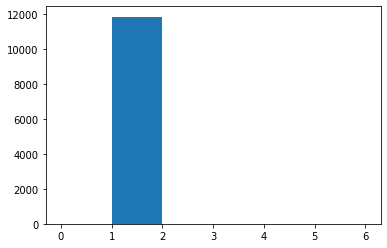

In [ ]:
#Shows missing data is only in Province_State column.
def No_obs(df):
    #find rows that have missing observations
    (r,c) = np.where(pd.isnull(df))

    return r,c
x,y =No_obs(File)
plt.hist(y, bins=6, range=[0,6])

In [ ]:
#Shows missing data is only in Province_State column.
def datechange(df):
  def date_to_nth_day(date, format='%Y-%m-%d'):
    date = pd.to_datetime(date, format=format)
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1
  df['Date'] = df['Date'].apply(date_to_nth_day)
  return df

File = datechange(File)
Testdata = datechange(Testdata)

In [ ]:
#Changes empty cells to copy the country.
def NaN_filler(df):
  x,y =No_obs(df)
  for i in range(len(x)):
    df.iloc[x[i],1]= df.iloc[x[i],2]
  return df

File = NaN_filler(File)
Testdata = NaN_filler(Testdata)

In [ ]:
#Took the Hubei province in China as evidence of a logistic function.
Hubei= File.loc[File['Province_State']=='Hubei']
Hubeix=Hubei['Date']
Hubeiy=Hubei['ConfirmedCases']
Hubeiz=Hubei['Fatalities']

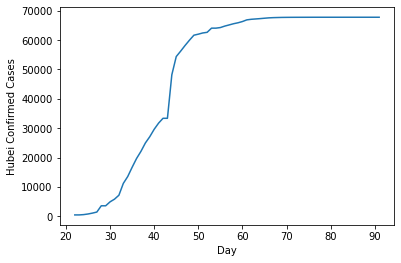

In [ ]:
#Plot of Hubei confirmed cases against the nth day of 2020.
plt.plot(Hubeix, Hubeiy)
plt.xlabel("Day")
plt.ylabel("Hubei Confirmed Cases")
plt.show()

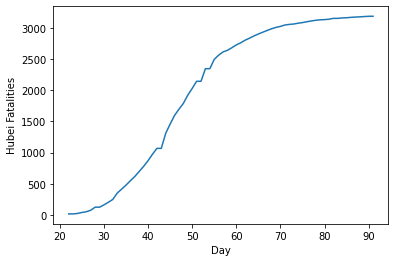

In [ ]:
#Plot of Hubei fatalities against the nth day of 2020.
plt.plot(Hubeix, Hubeiz)
plt.xlabel("Day")
plt.ylabel("Hubei Fatalities")
plt.show()

In [ ]:
#Splits Id from training data.
def Preparer(df):
    df_id = df[["Id"]]
    Data = df.drop(columns=["Id"],axis=1)
    return Data, df_id

Train_Data, Train_id = Preparer(File)

In [ ]:
#Defining of the logistic curve equation.
def logistic_curve(x,N,k,x0):
  return N/(1+np.exp(-k*(x-x0)))

In [ ]:
#Defining of curve fit function for both confirmed cases and 
#fatalities. They use different initial guesses whose values 
#I explain the choice of later on. Returns the optimised 
#predictions of N, k and x0.
from scipy.optimize import curve_fit

def Fit_CC(df,FirstCase):
  init_guess = [10000,0.22,FirstCase+62]
  fit = curve_fit(logistic_curve, 
                  df["Date"],
                  df["ConfirmedCases"], 
                  p0 = init_guess,
                  maxfev=10000)
  optimisers, cov = fit
  return optimisers

def Fit_Fat(df,FirstCase):
  
  init_guess = [100,0.31,FirstCase+64]
  fit = curve_fit(logistic_curve,
                  df["Date"],
                  df["Fatalities"], 
                  p0 = init_guess,
                  maxfev=10000)
  optimisers, cov = fit
  return optimisers

In [ ]:
#A trial fit on Hubei
Hubei_tmp=Train_Data.loc[Train_Data["Province_State"]=="Hubei"]
HubeiFirst= Hubei_tmp.ConfirmedCases.searchsorted(1, side='left')
opt = Fit_CC(Hubei_tmp,HubeiFirst)
opt

array([6.77437482e+04, 2.34686434e-01, 4.06945545e+01])

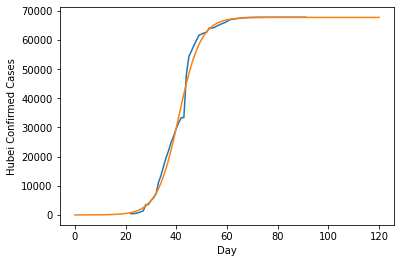

In [ ]:
#A plot of Hubei's actual confirmed cases in blue and the model 
#prediction in orange.
t=np.linspace(0,120,120)
plt.plot(Hubeix, Hubeiy)
plt.xlabel("Day")
plt.ylabel("Hubei Confirmed Cases")
plt.plot(t,logistic_curve(np.arange(120),opt[0],opt[1],opt[2]),label="model")

In [ ]:
#Gives a list of all unique provinces/countries in the given order.
All_Provinces=[]
for i in range(0,20580,70):
  state=File['Province_State'][i]
  All_Provinces.append(state)

In [ ]:
#For every province, the best values of N,k,x0 are calculated for 
#both confirmed cases and fatalities. These are stored in list_ 
#arrays. test_ arrays were used for estimating the best values of 
#initial guesses and for cases when there was too little data.
list_CCopt=[]
list_Fatopt=[]
test_CCopt=[]
test_Fatopt=[]
test_first=[]
#prov=[]
n=0
for i in All_Provinces:
  Province= Train_Data.loc[Train_Data["Province_State"]==i]
  FirstCase=Province.ConfirmedCases.searchsorted(1, side='left')
  if Province["ConfirmedCases"].max()>50:
    CCopt=Fit_CC(Province,FirstCase)
  else:
    CCopt=[10000,0.22,FirstCase+62]  
  list_CCopt.append(CCopt)  
  if Province["Fatalities"].max()>50:
    Fatopt=Fit_Fat(Province,FirstCase)
    test_CCopt.append(CCopt)
    test_Fatopt.append(Fatopt)
    test_first.append([0,0,FirstCase])
    prov.append(i)
  else:
    Fatopt=[list_CCopt[0][0]/25,list_CCopt[0][1],list_CCopt[n][2]+2]
  list_Fatopt.append(Fatopt)
  n+=1

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:
#Gives average number of days between first confirmed case and 
#inflection point as 61.8. Has standard deviation of 3.
First_case_dif=np.subtract(test_CCopt,test_first)
np.mean(First_case_dif,axis=0)[2]
np.std(First_case_dif,axis=0)[2]

In [ ]:
#Gave out 23 provinces which have over 50 total fatalities by the 
#end of the training data who could give estimates for good parameter 
#values.
len(test_CCopt)

In [ ]:
#Shows 1.94 day lag time between inflection point of Confirmed Cases 
#and Fatalities, rounded this to 2. The average difference in growth 
#rate is 0.14.
dif=np.subtract(test_CCopt,test_Fatopt)
np.mean(dif,axis=0)

array([ 1.23563346e+07,  1.47207300e-01, -8.67138209e+00])

In [ ]:
#Shows confirmed cases growth rate average of 0.22 with standard 
#deviation of 0.06.
np.mean(test_CCopt,axis=0)[1]
np.std(test_CCopt,axis=0)[1]

In [ ]:
#Showed Fatalities growth rate average of 0.31 but with standard 
#deviation 0.9 making it a less reliable initial guess.
np.mean(test_Fatopt,axis=0)[1]
np.std(test_Fatopt,axis=0)[1]

In [ ]:
#Shows ratio of 25 for confirmed cases total against fatalities 
#total. Hence on average there are 25 times less fatalities than 
#confirmed cases. Used geometric mean so outliers have less effect.
ratio=np.divide(test_CCopt,test_Fatopt)
from scipy.stats.mstats import gmean
gmean(ratio,axis=0)[0]

In [ ]:
#Generates predictions using the curve fit parameters on a logistic 
#equation.
CC_predict=[]
Fat_predict=[]
n=0
for i in All_Provinces:
  for x in range(79,122):
    tmp_CC_predict=logistic_curve(x,list_CCopt[n][0],list_CCopt[n][1],list_CCopt[n][2])
    CC_predict.append(round(tmp_CC_predict))
    tmp_Fat_predict=logistic_curve(x,list_Fatopt[n][0],list_Fatopt[n][1],list_Fatopt[n][2])
    Fat_predict.append(round(tmp_Fat_predict))
  n+=1 

In [ ]:
#Putting the results into a submittable format.
Results=Testdata[['ForecastId']]
Results["ConfirmedCases"]=CC_predict
Results["Fatalities"]=Fat_predict

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
Results.to_csv('COVID_predictions.csv', index=False)